# Autoencoder

### Imports

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
from keras.models import Model

Using TensorFlow backend.


In [4]:
from keras.layers import Input, Dense, Conv1D, Flatten, Reshape, UpSampling1D, MaxPool1D

## Read in Ca45 data

In [5]:
import numba as nb

In [6]:
def readData(fileName):
    dt = np.dtype([('header', '33c'), ('wf', '3500h')])
    s = os.stat(fileName)
    N = int((s.st_size - 8)/7033)
    with open(fileName, 'rb') as file:
        theader = np.core.records.fromfile(file,formats='Q',shape=1,byteorder='<')[0][0]
        file.seek(8)
        data = np.core.records.fromfile(file, dtype=dt ,shape=N,byteorder='<')
    return data['wf']

In [7]:
import os

In [8]:
data = readData('./Run_00120_11.bin')

In [9]:
@nb.jit(cache=True, nopython=True)
def bitLogic(x):
    for i in range(3500):
        x[i] &= 16383
        if x[i]>8191:
            x[i] -= 16384

In [10]:
for i in range(len(data)):
    bitLogic(data[i])

In [11]:
@nb.jit(cache=True, nopython=True)
def normBatch(x):
    base = np.mean(x[:400])
    for i in range(len(x)): x[i] = x[i] - base
    top = np.amax(x)
    for i in range(len(x)): x[i] = x[i] / top

In [12]:
data = data[(np.amax(data,1) - np.amin(data,1))>1000]

In [13]:
data = data.astype(np.float32)

In [14]:
normBatch(data[-2002])

In [15]:
for i in range(len(data)): normBatch(data[i])

In [16]:
np.random.shuffle(data)

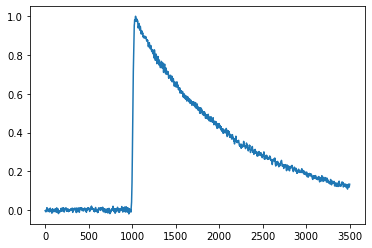

In [17]:
plt.plot(data[0])

In [18]:
from sklearn.cluster import KMeans

In [22]:
kmeans = KMeans(n_clusters=2, n_jobs=4)

In [23]:
data.shape

(32254, 3500)

In [24]:
np.random.shuffle(data)

In [26]:
kmeans.fit(data[:10**4])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=4, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

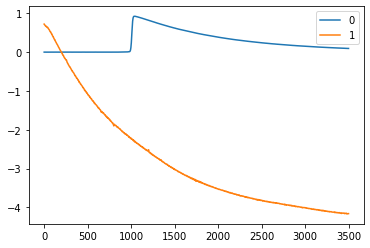

In [28]:
for i in range(len(kmeans.cluster_centers_)): plt.plot(kmeans.cluster_centers_[i], label=i);
plt.legend()

In [29]:
data = data[kmeans.predict(data)==0]

In [30]:
data.shape[0]/1e4

2.9482

## Apply Autoencoder

Set up the input size and the bottleneck

In [32]:
input_shape = data.shape[1]
bottleneck = 5

In [33]:
# this is our input placeholder
input_img = Input(shape=(input_shape,))

# encoder
encoded = Reshape((-1, 1))(input_img)

encoded = Conv1D(16, 8, activation='relu', padding='same')(encoded)
encoded = MaxPool1D(5, padding='same')(encoded)

encoded = Conv1D(16, 8, activation='relu', padding='same')(encoded)
encoded = MaxPool1D(5, padding='same')(encoded)

encoded = Conv1D(16, 8, activation='relu', padding='same')(encoded)
encoded = MaxPool1D(5, padding='same')(encoded)

encoded = Conv1D(16, 8, activation='relu', padding='same')(encoded)
encoded = MaxPool1D(2, padding='same')(encoded)

encoded = Conv1D(1, 8, activation='relu', padding='same')(encoded)
encoded = MaxPool1D(2, padding='same')(encoded)

# bottleneck 
encoded = Flatten()(encoded)
encoded = Dense(bottleneck, activation='relu', name='Bottleneck')(encoded)
decoded = Dense(7, activation='relu')(encoded)
decoded = Reshape((-1,1))(decoded)

# decoder
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(1, 8, activation='relu', padding='same')(decoded)

decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(16, 8, activation='relu', padding='same')(decoded)

decoded = UpSampling1D(5)(decoded)
decoded = Conv1D(16, 8, activation='relu', padding='same')(decoded)

decoded = UpSampling1D(5)(decoded)
decoded = Conv1D(16, 8, activation='relu', padding='same')(decoded)

decoded = UpSampling1D(5)(decoded)
decoded = Conv1D(1, 8, activation='sigmoid', padding='same')(decoded)

decoded = Flatten()(decoded)

autoencoder = Model(input_img, decoded)

In [34]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3500)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 3500, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3500, 16)          144       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 700, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 700, 16)           2064      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 140, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 140, 16)           2064

In [35]:
autoencoder.compile(optimizer='adadelta',loss='mse')

In [36]:
autoencoder.fit(data[:10**4],data[:10**4],epochs=10,validation_split=.2,use_multiprocessing=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 17s 2ms/step - loss: 0.0249 - val_loss: 0.0073
Epoch 2/10
8000/8000 [==============================] - 16s 2ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 3/10
8000/8000 [==============================] - 17s 2ms/step - loss: 0.0044 - val_loss: 0.0057
Epoch 4/10
8000/8000 [==============================] - 16s 2ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 5/10
8000/8000 [==============================] - 16s 2ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 6/10
8000/8000 [==============================] - 16s 2ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 7/10
8000/8000 [==============================] - 16s 2ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 8/10
8000/8000 [==============================] - 16s 2ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 9/10
8000/8000 [==============================] - 16s 2ms/step - loss: 0.0035 - val_loss: 0.0053
Epoch 10/10
8000/8000 [==

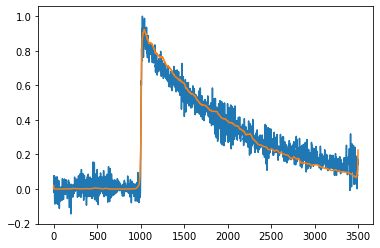

In [37]:
z = data[np.random.choice(np.arange(len(data)))]
plt.plot(z)
plt.plot(autoencoder.predict(z.reshape(1,-1)).flatten())

Extract the encoder

In [38]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(bottleneck,))

In [39]:
encoder.predict(data[:2]).flatten()

array([0.       , 4.648502 , 0.       , 5.193701 , 0.       , 0.       ,
       3.3914196, 0.       , 5.0170236, 0.       ], dtype=float32)

Extract the decoder

In [40]:
l = len(autoencoder.layers) - len(Model(input_img, encoded).layers)

In [41]:
a = Input(shape=(bottleneck,))

In [42]:
b = autoencoder.layers[-l](a)
for i in range(1,l):
    b = autoencoder.layers[-l:][i](b)

In [43]:
m = Model(a, b)

Make sure the extractions are right

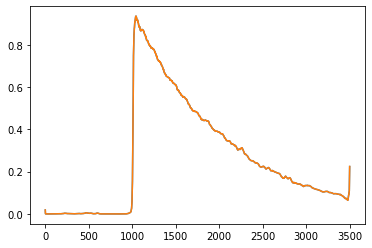

In [44]:
z = data[np.random.choice(np.arange(len(data)))]
plt.plot(autoencoder.predict(z.reshape(1,-1)).flatten())
plt.plot(m.predict(encoder.predict(z.reshape(1,-1))).flatten())